# VanillaGAN loss function graph

Ref: https://teddylee777.github.io/tensorflow/vanilla-gan

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

In [5]:
x_train.min(), x_train.max()

(-1.0, 1.0)

In [6]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

In [7]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 10

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
adam = Adam(lr=0.0002, beta_1=0.5)

In [9]:
generator = Sequential([
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(28*28, activation='tanh'),
])

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [11]:
discriminator = Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [13]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [14]:
# discriminator는 학습을 하지 않도록 하며, Gan 모델에서는 generator만 학습하도록 합니다.
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

In [15]:
gan = Model(gan_input, output)

In [16]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1463312   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


In [17]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [18]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [19]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [20]:
BATCH_SIZE = 128
EPOCHS= 100

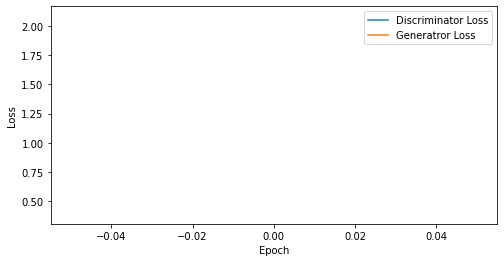

epoch: 1, Discriminator Loss: 0.39321812987327576, Generator Loss: 2.0821738243103027


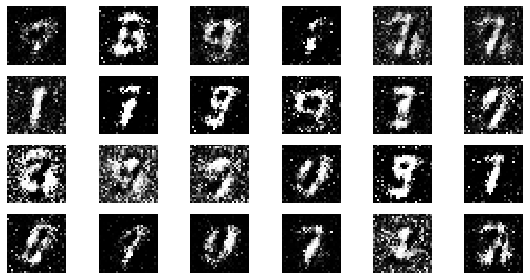

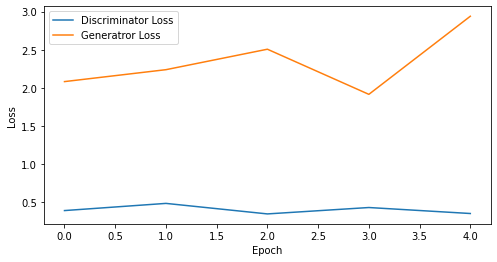

epoch: 5, Discriminator Loss: 0.40352978110313414, Generator Loss: 2.3360013008117675


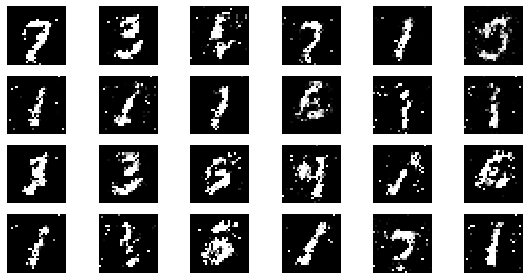

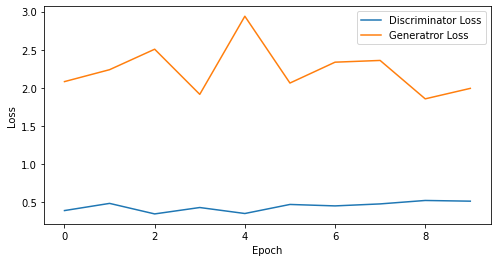

epoch: 10, Discriminator Loss: 0.44676439464092255, Generator Loss: 2.2288756489753725


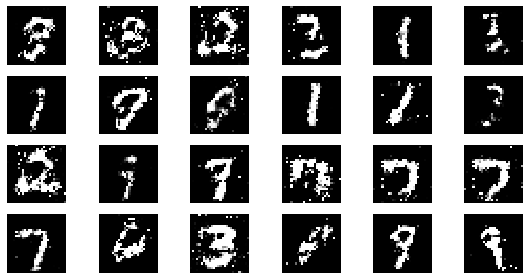

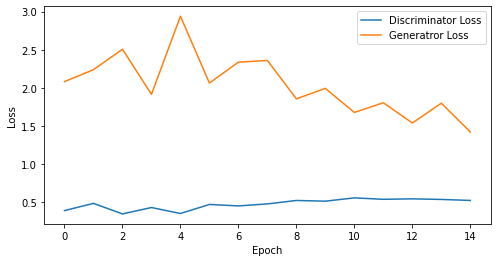

epoch: 15, Discriminator Loss: 0.47862555384635924, Generator Loss: 2.0355809688568116


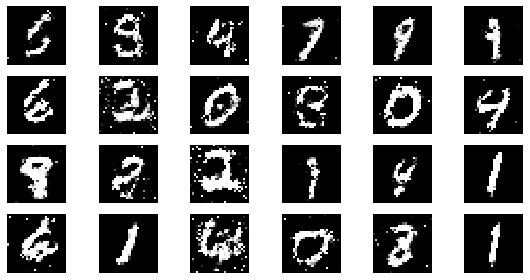

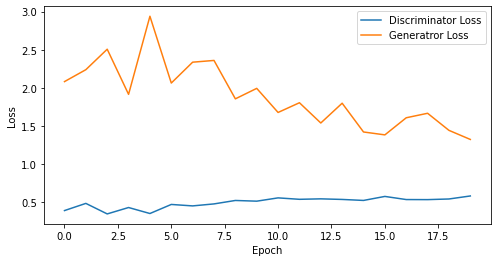

epoch: 20, Discriminator Loss: 0.4980595871806145, Generator Loss: 1.8981277644634247


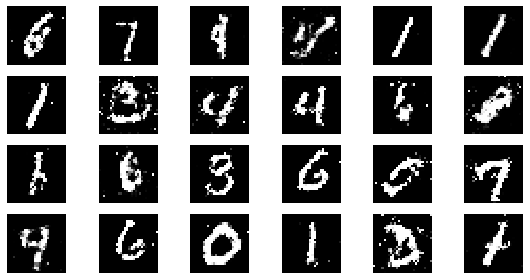

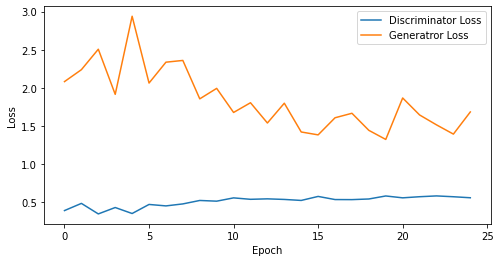

epoch: 25, Discriminator Loss: 0.5126487624645233, Generator Loss: 1.842827820777893


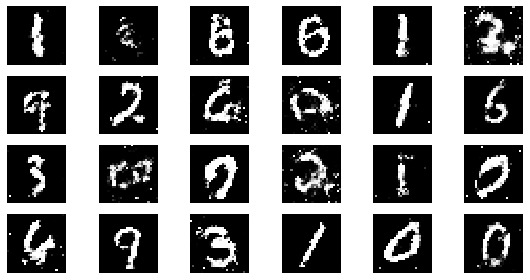

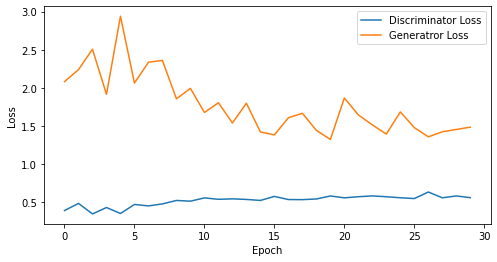

epoch: 30, Discriminator Loss: 0.5236783434947332, Generator Loss: 1.7758418838183085


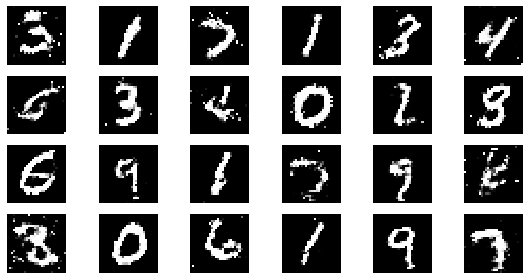

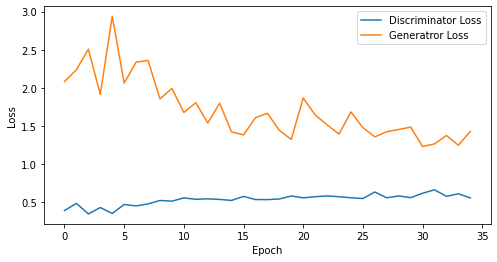

epoch: 35, Discriminator Loss: 0.535623493364879, Generator Loss: 1.7093957253864833


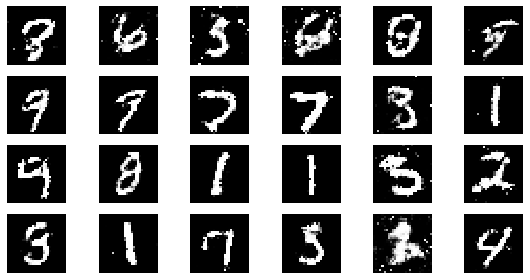

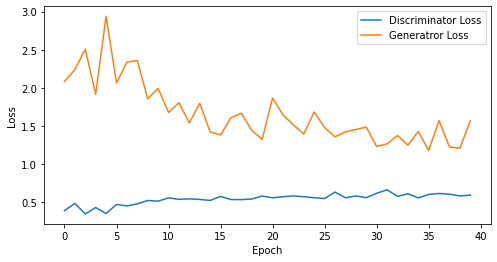

epoch: 40, Discriminator Loss: 0.5439600653946399, Generator Loss: 1.6645633012056351


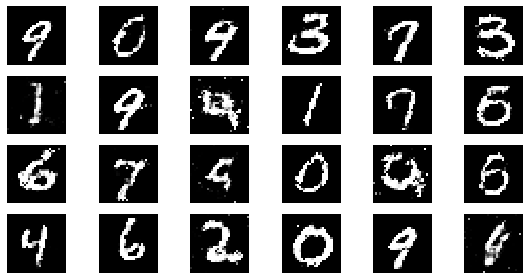

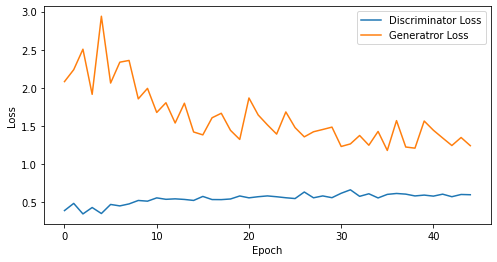

epoch: 45, Discriminator Loss: 0.5495108399126265, Generator Loss: 1.626880693435669


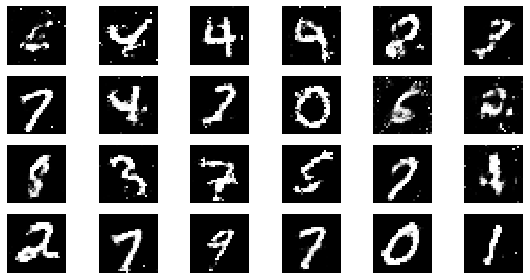

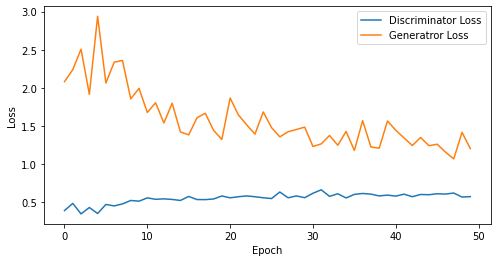

epoch: 50, Discriminator Loss: 0.5543860656023025, Generator Loss: 1.5864643812179566


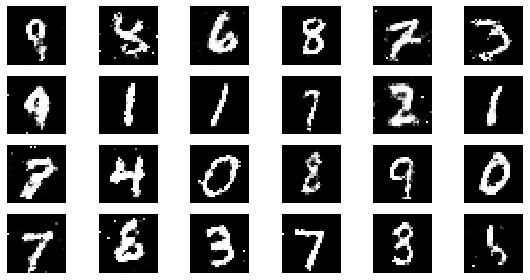

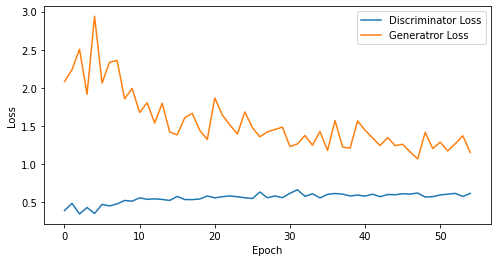

epoch: 55, Discriminator Loss: 0.5589208153161136, Generator Loss: 1.5560583743182095


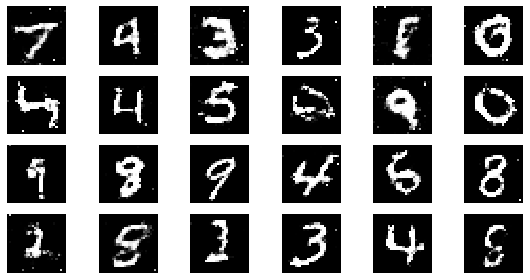

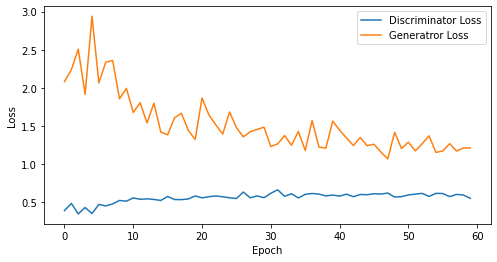

epoch: 60, Discriminator Loss: 0.5614638194441796, Generator Loss: 1.5270969529946645


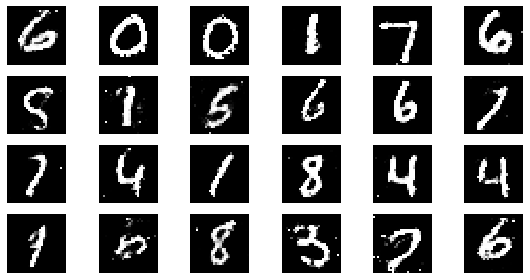

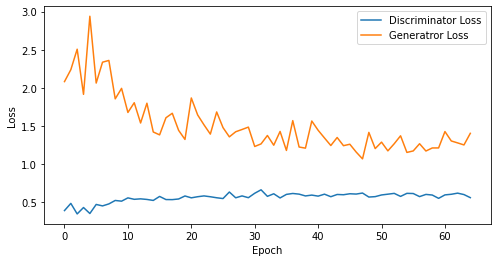

epoch: 65, Discriminator Loss: 0.5642982084017534, Generator Loss: 1.5122336002496573


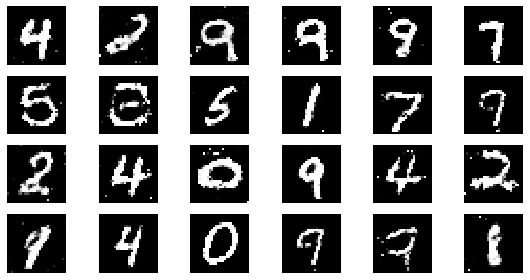

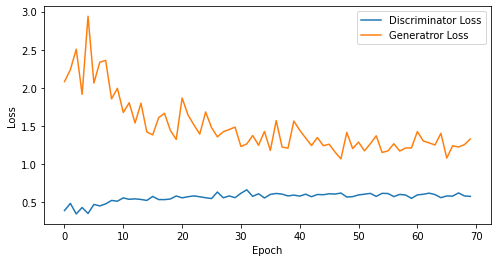

epoch: 70, Discriminator Loss: 0.5662024221249989, Generator Loss: 1.4918676393372672


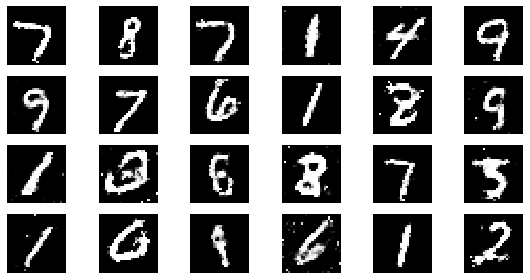

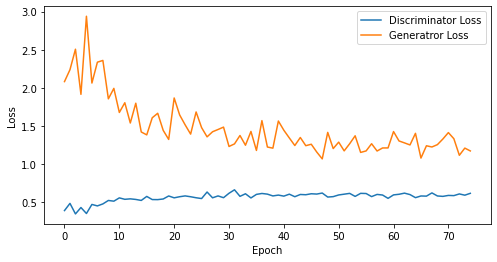

epoch: 75, Discriminator Loss: 0.5685288266340891, Generator Loss: 1.4757601499557496


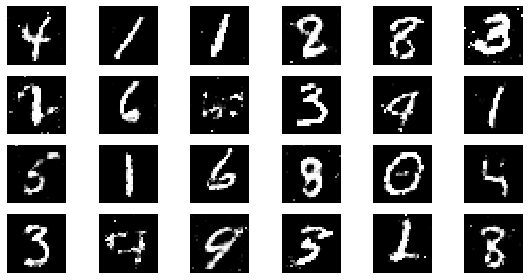

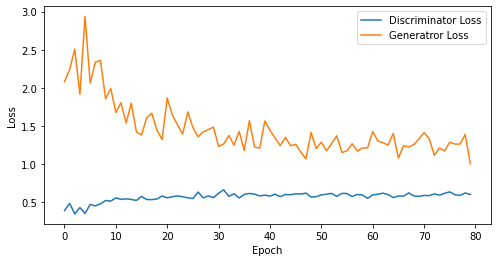

epoch: 80, Discriminator Loss: 0.5712136130779981, Generator Loss: 1.4612109526991843


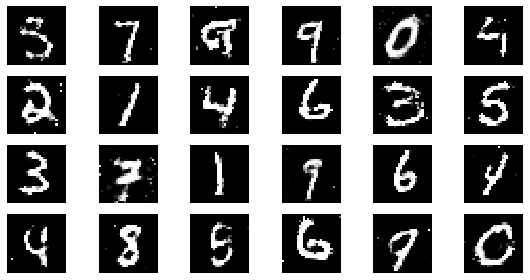

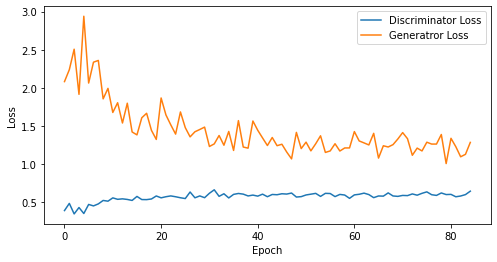

epoch: 85, Discriminator Loss: 0.5730582591365365, Generator Loss: 1.4468172746546129


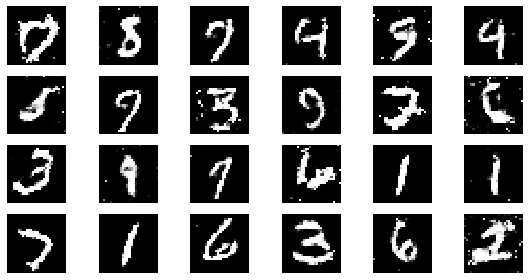

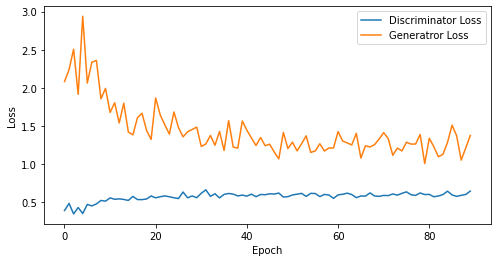

epoch: 90, Discriminator Loss: 0.574802052643564, Generator Loss: 1.4389919691615634


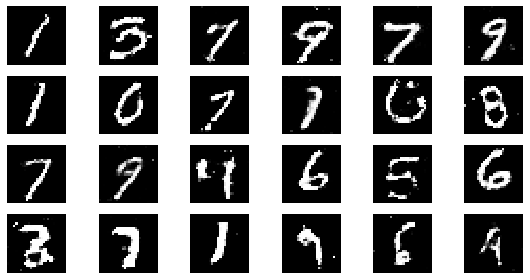

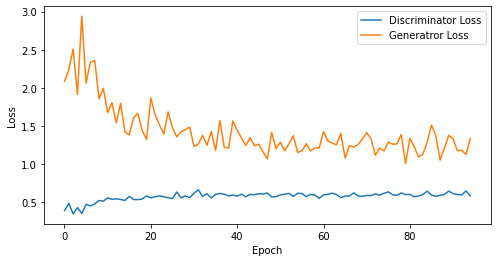

epoch: 95, Discriminator Loss: 0.5766911879966133, Generator Loss: 1.4281033892380564


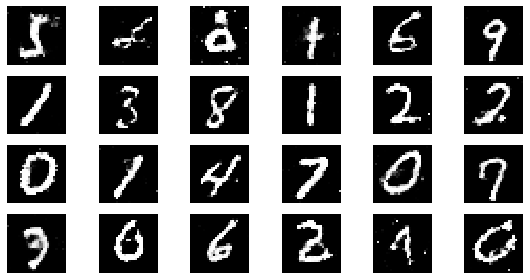

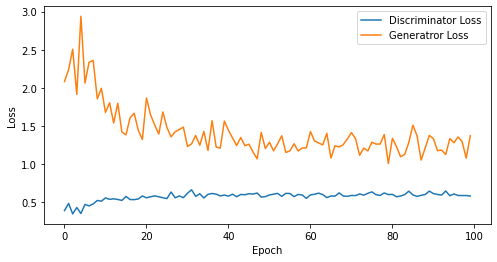

epoch: 100, Discriminator Loss: 0.5775096860527992, Generator Loss: 1.4205756652355195


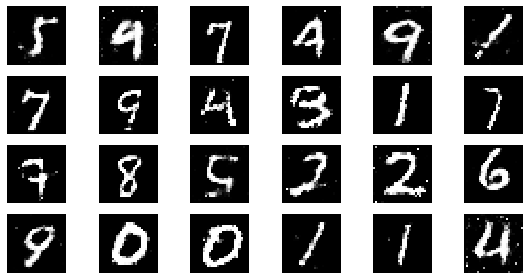

In [21]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)